<a href="https://colab.research.google.com/github/NITIN9694/TensorFlow-Learning/blob/main/07_Transfer_Learning_With_Tensorflow_(Scalling_Up)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning With Tensorflow part 3 : Scaling up

we've seen the power of tranfer learning  feature extraction and fine tuning, now its time to scale up to all of the class in food101
Our goal is to beat the original food101 papaer with 10% of tge training

In [1]:
 #check GPU
 !nvidia-smi

Sat Sep 20 06:40:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

##Create helper funcations


In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-09-20 07:39:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-09-20 07:39:23 (15.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
#Import series of helper funcations  for our notebook
from helper_functions import create_tensorboard_callback , plot_loss_curves, unzip_data,walk_through_dir,compare_historys

#101 food classes : working with less data
our goal is to beat the original food101 papaer with 10% of the training data , so lets download it.

The data we're downloading come from the original food101 dataset but has been preprocessed using the image_data_modification


In [7]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip


--2025-09-20 07:39:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 142.251.188.207, 74.125.20.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   187MB/s    in 11s     

2025-09-20 07:39:48 (147 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [8]:
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [6]:
#how many images/class are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/omelette'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/oysters'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/strawberry_shortcake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/guacamole'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/greek_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10

In [9]:
#setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode = "categorical",
                                                                               image_size = IMG_SIZE
                                                                                )

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle= False
                                                                )

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


##Train Big dog model with transfer learning on 10% of 101 food class
Here are the steps we're going to take:



*   Create ModelCheckpoint Callback
*   Create a data agumentation layer to build data agumnetation right into the model

*   Build a headless funcational EfficientNetB0 backbond -model
*   Feature extract for 5 full passes (5 epochs on the train data and validat on 15% of the test data to save epoch time)



In [18]:
#create checpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True
                                                         )

In [17]:
#Create data augmentation layer to incorporate it right into the model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth


#Setup data augmentation

data_augmentation =  Sequential(
    [
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2)
    ],
     name = "data_augmentation" )

In [19]:
#setup base model and freeze it

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

base_model =  tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top = False,
    input_shape = (224, 224, 3),
    weights = "imagenet"
)

base_model.trainable = False

input = layers.Input(shape = (224, 224, 3), name = "input_layer")
x = data_augmentation(input)

x = base_model(x,training=False)

# Global average pooling
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Output layer
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(input, outputs)

In [20]:
#compile
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"]
              )

#fit
history_all_class_10_percenat = model.fit(
    train_data_all_10_percent,
    epochs = 5,

    validation_data =   test_data,
    validation_steps = int(0.25 * len(test_data)),
     callbacks = [checkpoint_callback]
                                          )

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 106s 380ms/step - accuracy: 0.1352 - loss: 4.0671 - val_accuracy: 0.3320 - val_loss: 2.8400
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 122s 315ms/step - accuracy: 0.4198 - loss: 2.6125 - val_accuracy: 0.4291 - val_loss: 2.3182
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 66s 279ms/step - accuracy: 0.4807 - loss: 2.2045 - val_accuracy: 0.4753 - val_loss: 2.0695
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 79s 267ms/step - accuracy: 0.5211 - loss: 1.9632 - val_accuracy: 0.5049 - val_loss: 1.9263
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 57s 241ms/step - accuracy: 0.5495 - loss: 1.8246 - val_accuracy: 0.5148 - val_loss: 1.8688


In [12]:
#evaluate the modelm
fine_tuning_result = model.evaluate(test_data)
fine_tuning_result

790/790 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.5393 - loss: 1.7653


[1.6672168970108032, 0.5608713030815125]

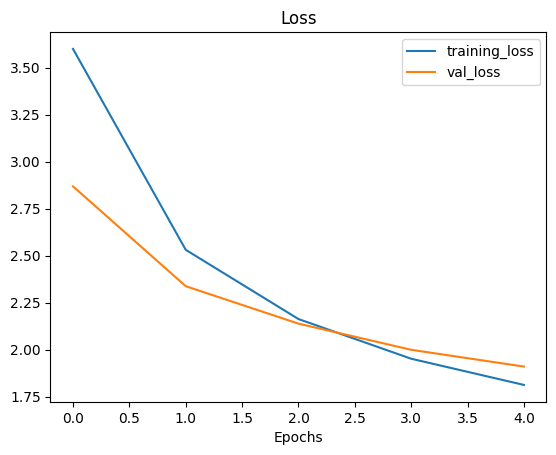

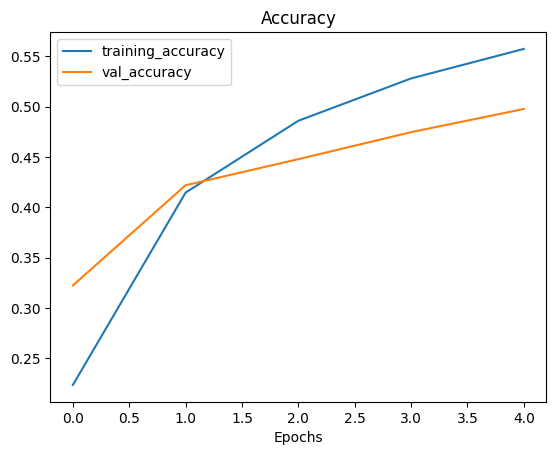

In [13]:
#Plot los curve
plot_loss_curves(history_all_class_10_percenat)

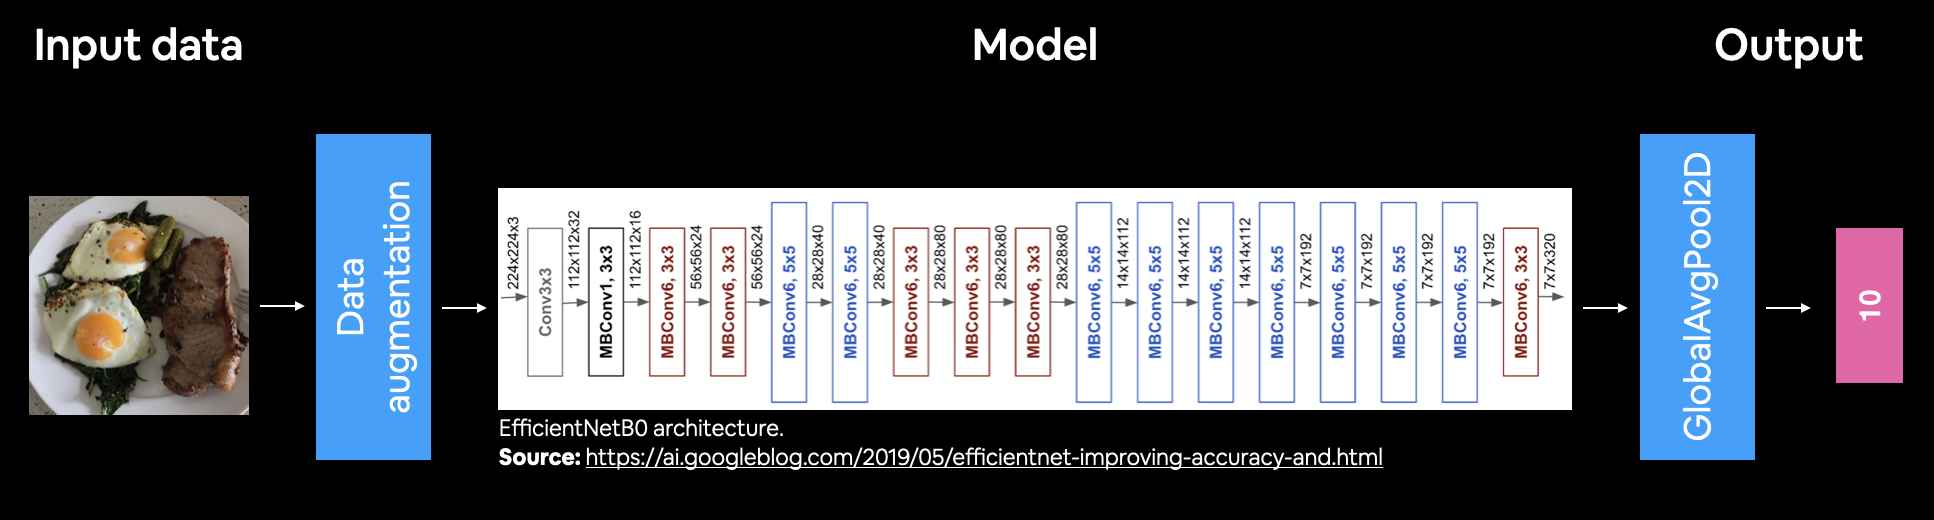

🤔 Question: What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not, there may be some overfitting or underfitting.

#Fine-tuning
Our feature extraction transfer learning model is performing well. Why don't we try to fine-tune a few layers in the base model and see if we gain any improvements?

The good news is, thanks to the ModelCheckpoint callback, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its trainable attribute to True, unfreezing all of the frozen.

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

In [21]:
#unfreeze all of the layers in the base model
base_model.trainable = True

#Refreeze every layers except the last 5
for layer in base_model.layers[:-5] :
  layer.trainable = False

In [14]:
model.compile(loss = "categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default

            metrics=['accuracy']
              )

NameError: name 'model' is not defined

In [16]:

# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetv2-b0 True
global_average_pooling_layer True
output_layer True


In [17]:
history_all_classes_10_percent_fine_tune = model.fit(
    train_data_all_10_percent,
    epochs = 10,
    validation_data = test_data,
     validation_steps = int(0.15 * len(test_data)),
    initial_epoch=history_all_class_10_percenat.epoch[-1]

)

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 66s 227ms/step - accuracy: 0.5519 - loss: 1.9608 - val_accuracy: 0.5016 - val_loss: 2.0158
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 52s 218ms/step - accuracy: 0.5782 - loss: 1.7875 - val_accuracy: 0.5196 - val_loss: 1.8964
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 78s 200ms/step - accuracy: 0.6075 - loss: 1.6854 - val_accuracy: 0.5381 - val_loss: 1.8188
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 179ms/step - accuracy: 0.6251 - loss: 1.5858 - val_accuracy: 0.5389 - val_loss: 1.7788
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 179ms/step - accuracy: 0.6219 - loss: 1.5610 - val_accuracy: 0.5498 - val_loss: 1.7354
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 80s 173ms/step - accuracy: 0.6253 - loss: 1.5137 - val_accuracy: 0.5519 - val_loss: 1.7251


In [18]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 ━━━━━━━━━━━━━━━━━━━━ 54s 68ms/step - accuracy: 0.5733 - loss: 1.6125


[1.495285153388977, 0.5994455218315125]

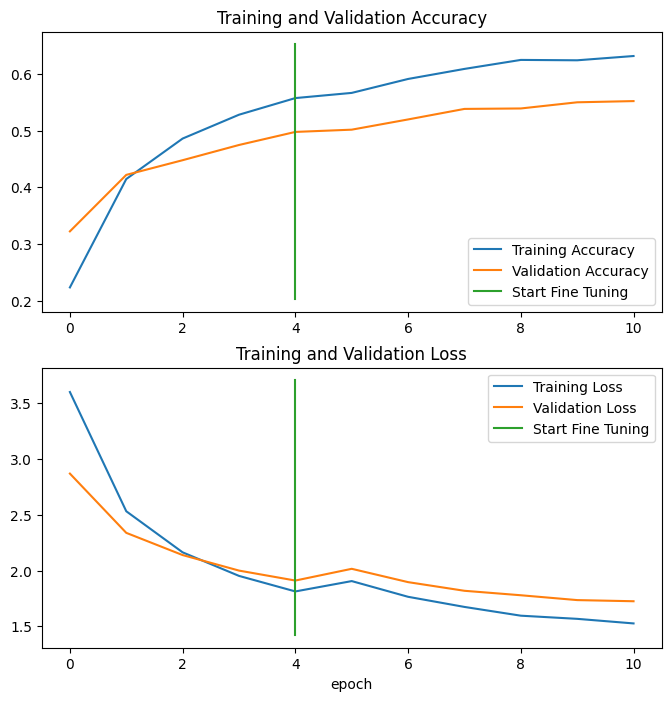

In [19]:
compare_historys(original_history = history_all_class_10_percenat,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5
                 )

##Saving and load model

To use the modle extrenal application we'll need to export and save the model

In [20]:
model.save("drive/MyDrive/Models/101_Food_class_10_percenatge_model.keras")

#Evaluating the performance of the big dog model across all different classes
We've got a trained and saved model which according to the evaluation metrics we've used is performing fairly well.

But metrics schmetrics, let's dive a little deeper into our model's performance and get some visualizations going.

To do so, we'll load in the saved model and use it to make some predictions on the test dataset.

🔑 Note: Evaluating a machine learning model is as important as training one. Metrics can be deceiving. You should always visualize your model's performance on unseen data to make sure you aren't being fooled good looking training numbers.

In [21]:
import tensorflow as tf
#download pre train model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2025-09-20 06:56:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.135.207, 192.178.163.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   133MB/s    in 0.3s    

2025-09-20 06:56:12 (133 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [22]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [3]:
# Load the model using TFSMLayer
import keras
model = keras.layers.TFSMLayer("/content/06_101_food_class_10_percent_saved_big_dog_model", call_endpoint='serving_default')

In [ ]:
# Make predictions with the loaded model
# TFSMLayer expects a dictionary input with a tensor or numpy array
import numpy as np

# Extract images from the test_data dataset and convert to numpy array
test_images = np.concatenate([x.numpy() for x, y in test_data], axis=0)



In [2]:
# Load the model using TFSMLayer
import keras

predictions = model.predict({'input_layer': test_images})

NameError: name 'model' is not defined

In [ ]:
# How many predictions are there?
len(pred_probs)

In [13]:

pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

NameError: name 'model' is not defined

As we discussed before, for each image tensor we pass to our model, because of the number of output neurons and activation function in the last layer (`layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax"`), it outputs a prediction probability between 0 and 1 for all each of the 101 classes.

And the index of the highest prediction probability can be considered what the model thinks is the most likely label. Similarly, the lower prediction probaiblity value, the less the model thinks that the target image is that specific class.

> 🔑 **Note:** Due to the nature of the softmax activation function, the sum of each of the prediction probabilities for a single sample will be 1 (or at least very close to 1). E.g. `pred_probs[0].sum() = 1`.

We can find the index of the maximum value in each prediction probability tensor using the `argmax()` method.

In [10]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0)]

In [11]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

25250

### Evaluating our models predictions

A very simple evaluation is to use Scikit-Learn's [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function which compares truth labels to predicted labels and returns an accuracy score.

If we've created our `y_labels` and `pred_classes` arrays correctly, this should return the same accuracy value (or at least very close) as the `evaluate()` method we used earlier.

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels,pred_classes)